In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import os
import cv2

# Function to load preprocessed images
def load_preprocessed_images(data_dir, image_size=(100, 100)):
    images = []
    labels = []
    class_names = os.listdir(data_dir)  # Assuming each subdirectory is a class

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        
        if not os.path.isdir(class_dir):  # Skip if not a directory
            continue

        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            
            # Load image
            image = cv2.imread(img_path)
            if image is None:
                print(f"Warning: Could not read {img_path}")
                continue
            
            # Resize the image to the desired size
            image = cv2.resize(image, image_size)
            
            # Normalize the image
            image = image / 255.0
            
            images.append(image)
            labels.append(class_name)  # Store the class name

    return np.array(images), np.array(labels)

# Step 1: Load preprocessed images
data_directory = '../data/processed'  # Update with your path
original_images, y = load_preprocessed_images(data_directory)

# Step 2: Preprocess labels
label_map = {label: idx for idx, label in enumerate(np.unique(y))}
y_encoded = np.array([label_map[label] for label in y])
y_categorical = to_categorical(y_encoded)

# Step 3: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(original_images, y_categorical, test_size=0.2, random_state=42)

# Step 4: Initialize PCA and fit it on training data
n_components = 100
pca = PCA(n_components=n_components)
X_train_flattened = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
X_train_pca = pca.fit_transform(X_train_flattened)

# Transform the test data using the fitted PCA model
X_test_flattened = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2] * X_test.shape[3])
X_test_pca = pca.transform(X_test_flattened)

# Step 5: Initialize the data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Note: Data augmentation is typically applied to the original images, not PCA-transformed features.
# So we won't use `datagen` on PCA-transformed data.
# Step 5: Define the ANN model with more layers
model = Sequential()
model.add(Input(shape=(n_components,)))  # Define the input shape with Input layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_map), activation='softmax'))  # Adjust output layer for number of classes

# Step 6: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 8: Train the model
history = model.fit(
    X_train_pca,  # Use PCA-transformed training data
    y_train,
    validation_data=(X_test_pca, y_test),
    epochs=50,
    batch_size=32
)

# Step 9: Evaluate the model
y_pred = model.predict(X_test_pca)
y_pred_classes = np.argmax(y_pred, axis=1)

              precision    recall  f1-score   support

           0       0.85      0.80      0.82       233
           1       0.97      1.00      0.98       224
           2       0.76      0.71      0.73       188
           3       0.77      0.84      0.81       199

    accuracy                           0.84       844
   macro avg       0.84      0.84      0.84       844
weighted avg       0.84      0.84      0.84       844

[[186   2  24  21]
 [  0 224   0   0]
 [ 24   2 133  29]
 [ 10   4  17 168]]


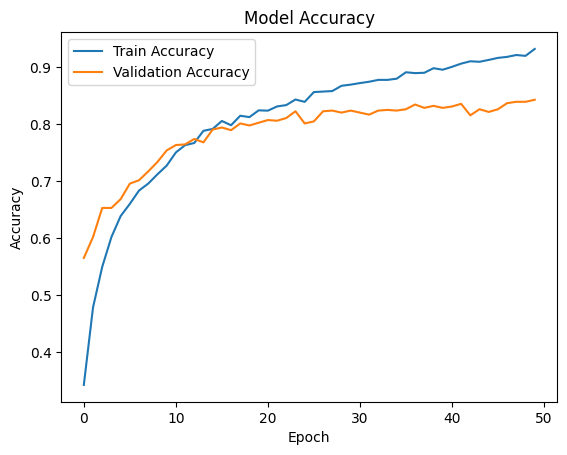

In [30]:
# Step 10: Generate classification report and confusion matrix
print(classification_report(np.argmax(y_test, axis=1), y_pred_classes))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes))

# Optional: Visualize training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [31]:
model.save('model.keras')
print("Model saved as model.keras")

Model saved as model.keras
